# Assignment 2 - Classification
## Group D - Members:
1. Venkateshprasad Kulkarni
2. Reena Sajad Hyder
3. Pravinkumar Yadav
4. Milad Ghavami

## 1. Importing required libraies and creating a logger for the code

### i. Importing libraries

In [1]:
import logging
import datetime
import pandas as pd
from sklearn.utils import resample
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

### ii. Creating a logger to generate logs for the entire code

In [2]:
# Configure the logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create a logger
logger = logging.getLogger(__name__)

## 2. Loading the CSV data file in a dataframe

In [3]:
start_time = datetime.datetime.now()
# Import data from csv file:
import pandas as pd
input_data = pd.read_csv('data/lc_14to16.csv')   
stop_time = datetime.datetime.now()
logger.info(f"Time taken to load the csv file: {stop_time - start_time}")
rows, columns = input_data.shape
logger.info(f"The Dataframe has {rows} rows and {columns} columns.")

C:\Users\ydpra\AppData\Local\Temp\ipykernel_13384\1903399938.py:4: DtypeWarning: Columns (19,59,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.
  input_data = pd.read_csv('data/lc_14to16.csv')
2024-10-09 14:11:48 - INFO - Time taken to load the csv file: 0:00:18.528589
2024-10-09 14:11:48 - INFO - The Dataframe has 1091131 rows and 151 columns.


## 3. Data Cleaning
### i. Transforming the dataframe to keep the necessary/required columns for further processing.

In [4]:
# Selecting the necessary columns from the dataframe
required_columns = ['loan_amnt', 'issue_d', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'dti', 'delinq_2yrs', 
                    'mths_since_last_delinq', 'pub_rec', 'open_acc', 'total_acc', 'application_type', 'annual_inc_joint', 'dti_joint', 
                    'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_bal_il', 'il_util', 'max_bal_bc', 
                    'total_rev_hi_lim', 'bc_util', 'all_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc', 'pct_tl_nvr_dlq',
                    'pub_rec_bankruptcies', 'tax_liens', 'revol_bal', 'revol_util', 'fico_range_low', 'fico_range_high', 'loan_status']
input_data = input_data[required_columns]
modified_rows, modified_columns = input_data.shape
logger.info(f"The modified Dataframe has {modified_rows} rows and {modified_columns} columns.")

2024-10-09 14:11:48 - INFO - The modified Dataframe has 1091131 rows and 37 columns.


### ii. Checking if any of the numerical attributes have string or text data

In [5]:
# Convert the specified columns to numeric, coerce errors to NaN
numerical_columns = ['loan_amnt', 'issue_d', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 'pub_rec', 'open_acc', 'total_acc', 
                 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_bal_il', 'il_util', 
                 'max_bal_bc', 'total_rev_hi_lim', 'bc_util', 'all_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc',
                 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'revol_bal', 'revol_util', 'fico_range_low', 'fico_range_high']
  


# Function to check if values are non-numeric or empty cell
def count_non_numeric_values(series):
    return series.apply(pd.to_numeric, errors='coerce').isna().sum()

# Apply the function to each column and get the count of non-numeric rows per column
non_numeric_counts = input_data[numerical_columns].apply(count_non_numeric_values)

logger.info("Number of rows with non-numeric values for each column:")
logger.info(non_numeric_counts)

2024-10-09 14:13:24 - INFO - Number of rows with non-numeric values for each column:
2024-10-09 14:13:24 - INFO - loan_amnt                         0
issue_d                     1091131
annual_inc                        0
dti                              65
delinq_2yrs                       0
mths_since_last_delinq       524671
pub_rec                           0
open_acc                          0
total_acc                         0
annual_inc_joint            1081831
dti_joint                   1081835
acc_now_delinq                    0
tot_coll_amt                      0
tot_cur_bal                       0
total_bal_il                 635413
il_util                      695516
max_bal_bc                   635413
total_rev_hi_lim                  0
bc_util                       11673
all_util                     635436
chargeoff_within_12_mths          0
delinq_amnt                       0
mort_acc                          0
pct_tl_nvr_dlq                    0
pub_rec_bankruptcies  

### iii. Cleaning non-numerical attributes

In [6]:
text_columns = ['grade', 'emp_length', 'home_ownership', 'verification_status', 'application_type', 'verification_status_joint']

# Combine employment length into 3 categories:
## '< 1 year', '1 year' = 0-1 years
## '2 years, 3 years, 4 years =  2-4 years
## everything else =  5+ years
input_data["emp_length"] = input_data["emp_length"].replace(['< 1 year', '1 year'], '0-1 years')
input_data["emp_length"] = input_data["emp_length"].replace(['2 years', '3 years', '4 years', '5 years'], '2-5 years')
input_data["emp_length"] = input_data["emp_length"].replace([ '6 years', '7 years', '8 years', '9 years', '10+ years'], '5+ years')

# Pravin
input_data = input_data[input_data.home_ownership != "ANY"]
def high_low(grade):
    if grade in ['A','B']:
        return 'High'
    else:
        return 'Low'
    
def high_medium_low(grade):
    if grade in ['A','B']:
        return 'High'
    elif grade in ['C']:
        return 'Medium'
    else:
        return 'Low'
    
input_data['high_low'] = input_data['grade'].apply(high_low)
input_data['high_medium_low'] = input_data['grade'].apply(high_medium_low)
grade_map = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
input_data['loan_grade_numeric'] = input_data['grade'].map(grade_map)
input_data.head()

,loan_amnt,issue_d,grade,emp_length,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,mths_since_last_delinq,...,pub_rec_bankruptcies,tax_liens,revol_bal,revol_util,fico_range_low,fico_range_high,loan_status,high_low,high_medium_low,loan_grade_numeric
0,3600.0,2015-12-01,C,5+ years,MORTGAGE,55000.0,Not Verified,5.91,0.0,30.0,...,0.0,0.0,2765.0,29.7,675.0,679.0,Fully Paid,Low,Medium,3
1,24700.0,2015-12-01,C,5+ years,MORTGAGE,65000.0,Not Verified,16.06,1.0,6.0,...,0.0,0.0,21470.0,19.2,715.0,719.0,Fully Paid,Low,Medium,3
2,20000.0,2015-12-01,B,5+ years,MORTGAGE,63000.0,Not Verified,10.78,0.0,NaN,...,0.0,0.0,7869.0,56.2,695.0,699.0,Fully Paid,High,High,2
3,35000.0,2015-12-01,C,5+ years,MORTGAGE,110000.0,Source Verified,17.06,0.0,NaN,...,0.0,0.0,7802.0,11.6,785.0,789.0,Current,Low,Medium,3
4,10400.0,2015-12-01,F,2-5 years,MORTGAGE,104433.0,Source Verified,25.37,1.0,12.0,...,0.0,0.0,21929.0,64.5,695.0,699.0,Fully Paid,Low,Low,6


## 4. Descriptive Statistics

Calculating summary statistics for numerical features such as `loan_amnt`, `annual_inc`, `dti`, `total_acc`, `acc_now_delinq`, `fico_range_low`, and `fico_range_high`. Understand the central tendency, dispersion, and distribution of these variables.

In [7]:
# List of numerical features to analyze
numerical_features = ['loan_amnt', 'annual_inc', 'dti', 'total_acc', 'acc_now_delinq', 'fico_range_low', 'fico_range_high']

### i. Removing null values from the required numerical features

In [8]:
# Convert columns to numeric, invalid parsing will be set as NaN
input_data[numerical_features] = input_data[numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
input_data_non_null = input_data.dropna(subset=numerical_features)

# Verify that all specified columns are numerical
logger.debug(input_data_non_null[numerical_features].dtypes)

2024-10-09 14:13:27 - DEBUG - loan_amnt          float64
annual_inc         float64
dti                float64
total_acc          float64
acc_now_delinq     float64
fico_range_low     float64
fico_range_high    float64
dtype: object


### ii. Calculating the summary statistics for the required numerical values

In [9]:
def display_summary_statistics(dataframe, numerical_features):
    # Calculate summary statistics
    summary_statistics = dataframe[numerical_features].describe()

    # Display the summary statistics
    logger.info("Summary Statistics:")
    print(summary_statistics)

display_summary_statistics(input_data_non_null, numerical_features)

2024-10-09 14:13:27 - INFO - Summary Statistics:


          loan_amnt    annual_inc           dti     total_acc  acc_now_delinq  \
count  1.090953e+06  1.090953e+06  1.090953e+06  1.090953e+06    1.090953e+06   
mean   1.495906e+04  7.752137e+04  1.879618e+01  2.521789e+01    6.289913e-03   
std    8.716234e+03  7.180973e+04  9.360309e+00  1.203646e+01    8.597952e-02   
min    1.000000e+03  2.000000e+02 -1.000000e+00  2.000000e+00    0.000000e+00   
25%    8.000000e+03  4.700000e+04  1.235000e+01  1.600000e+01    0.000000e+00   
50%    1.305000e+04  6.500000e+04  1.823000e+01  2.300000e+01    0.000000e+00   
75%    2.000000e+04  9.200000e+04  2.480000e+01  3.200000e+01    0.000000e+00   
max    4.000000e+04  9.573072e+06  9.990000e+02  1.760000e+02    1.400000e+01   

       fico_range_low  fico_range_high  
count    1.090953e+06     1.090953e+06  
mean     6.940887e+02     6.980888e+02  
std      3.048333e+01     3.048395e+01  
min      6.600000e+02     6.640000e+02  
25%      6.700000e+02     6.740000e+02  
50%      6.850000e+02   

### iii. Calculating the values variance, skewness, kurtosis for understanding the central tendency, dispersion

In [10]:
# Calculate variance
variance = input_data_non_null[numerical_features].var()
print("\nVariance Values:")
print(variance)

# Calculate skewness
skewness = input_data_non_null[numerical_features].skew()
print("\nSkewness Values:")
print(skewness)

# Calculate kurtosis
kurtosis = input_data_non_null[numerical_features].kurt()
print("\nKurtosis Values:")
print(kurtosis)


Variance Values:
loan_amnt          7.597274e+07
annual_inc         5.156637e+09
dti                8.761538e+01
total_acc          1.448764e+02
acc_now_delinq     7.392478e-03
fico_range_low     9.292334e+02
fico_range_high    9.292714e+02
dtype: float64

Skewness Values:
loan_amnt           0.693810
annual_inc         44.946288
dti                12.544792
total_acc           0.973012
acc_now_delinq     19.272224
fico_range_low      1.353478
fico_range_high     1.353688
dtype: float64

Kurtosis Values:
loan_amnt            -0.266286
annual_inc         4392.221450
dti                1127.828940
total_acc             1.769743
acc_now_delinq      966.859302
fico_range_low        2.040802
fico_range_high       2.042386
dtype: float64


## 5. Distribution Analysis

Plot histograms or density plots for key numerical features like `loan_amnt`, `annual_inc`, `dti`, `total_acc`, `acc_now_delinq`, `fico_range_low`, and `fico_range_high`. Analyze the distribution of these features to identify any skewness or outliers.

2024-10-09 14:13:30 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-09 14:13:30 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-09 14:13:30 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-10-09 14:13:30 - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\ydpra\\.conda\\envs\\airbnb\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-10-09 14:13:30 - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\ydpra\\.conda\\envs\\airbnb\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-10-09 14:13:30 - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\ydpra\\.c

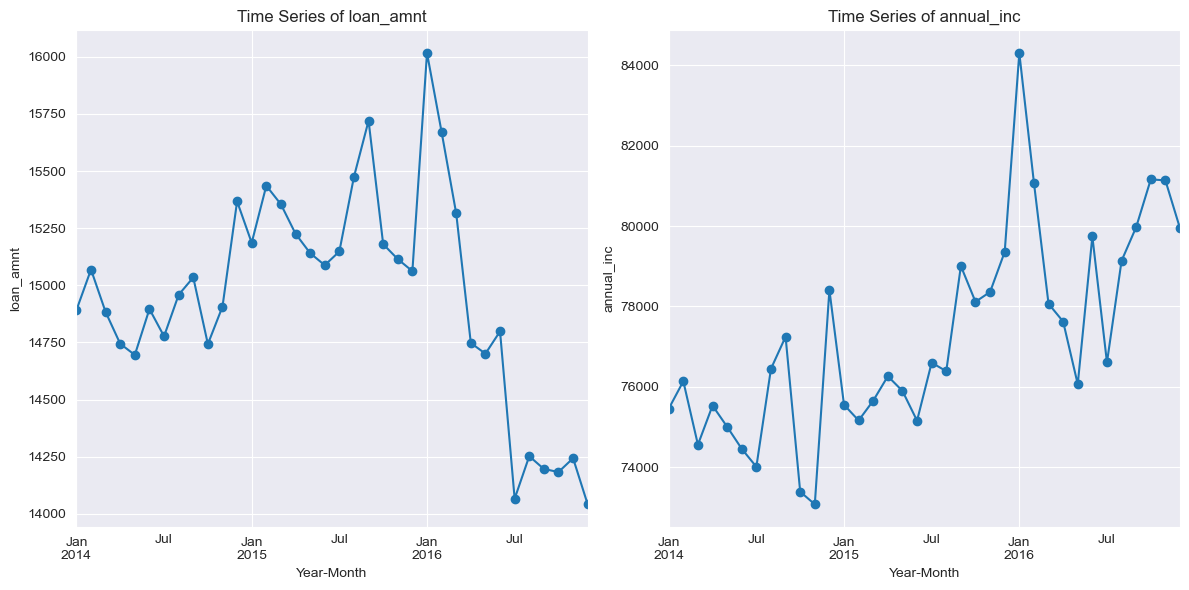

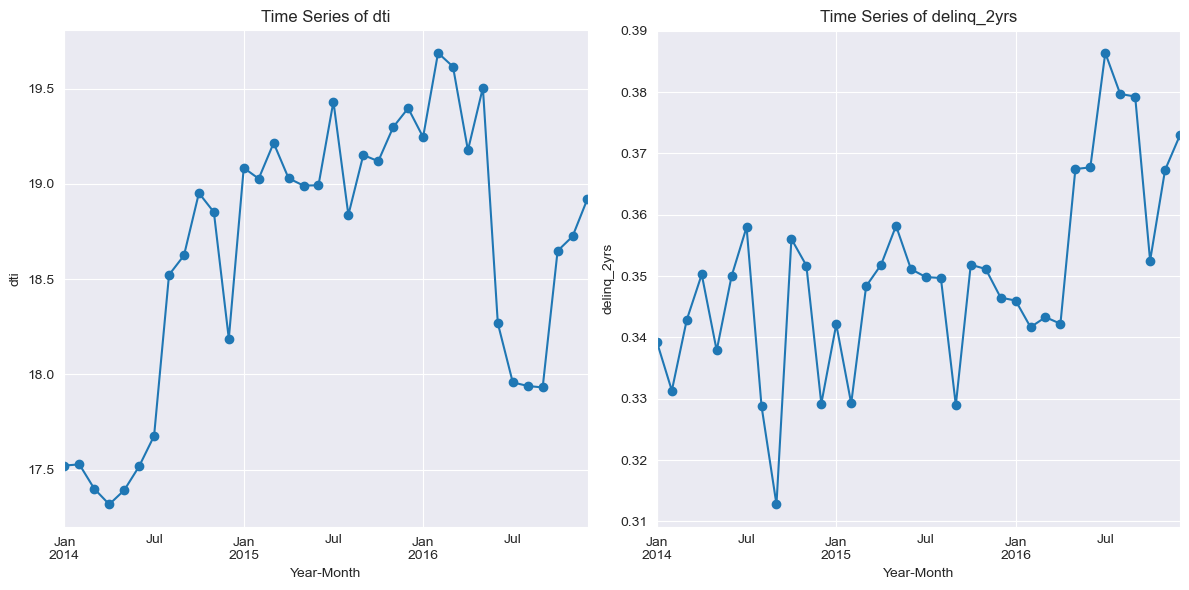

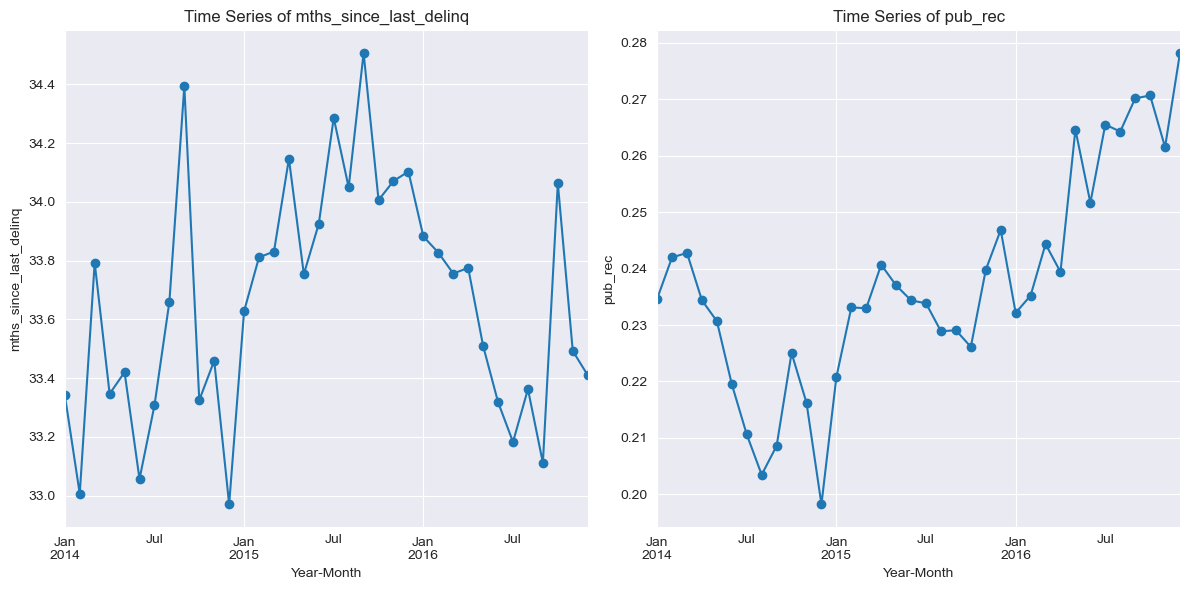

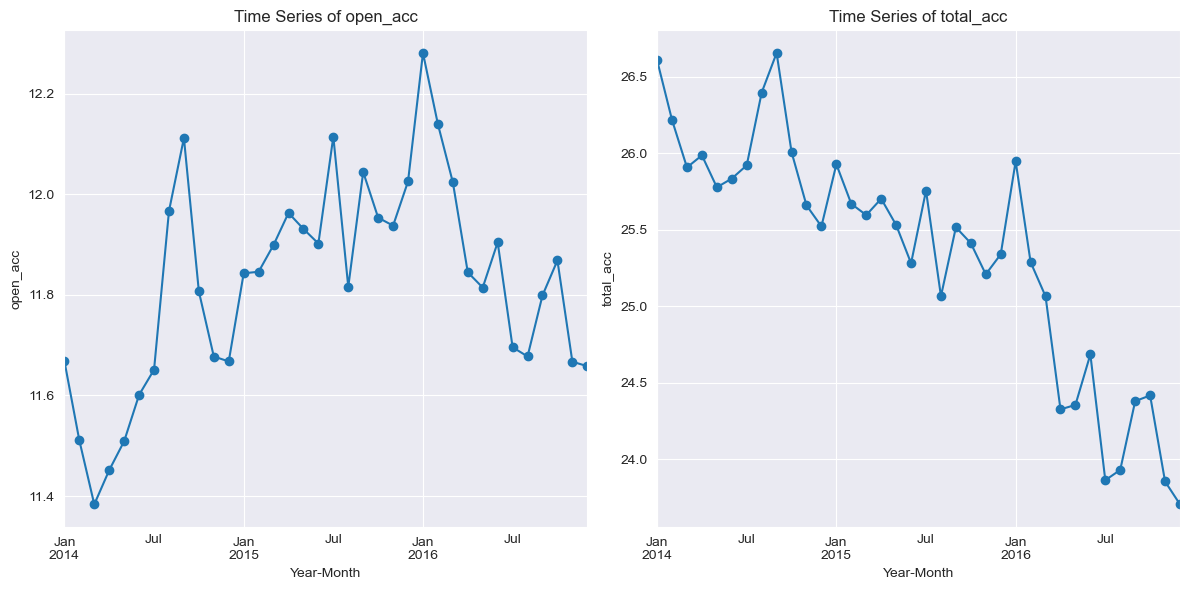

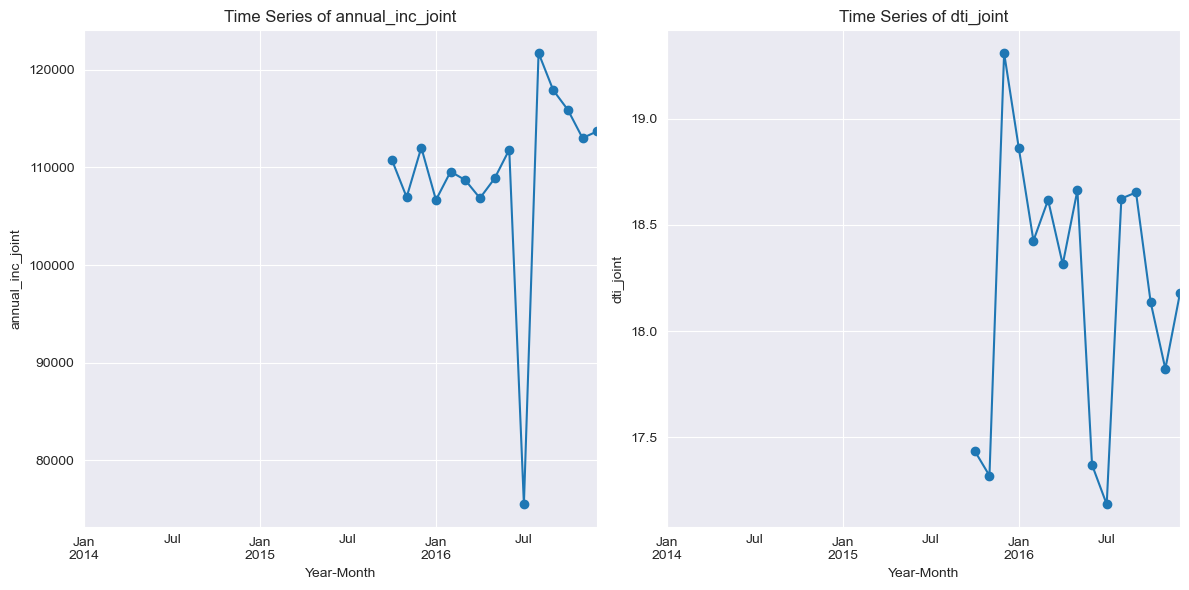

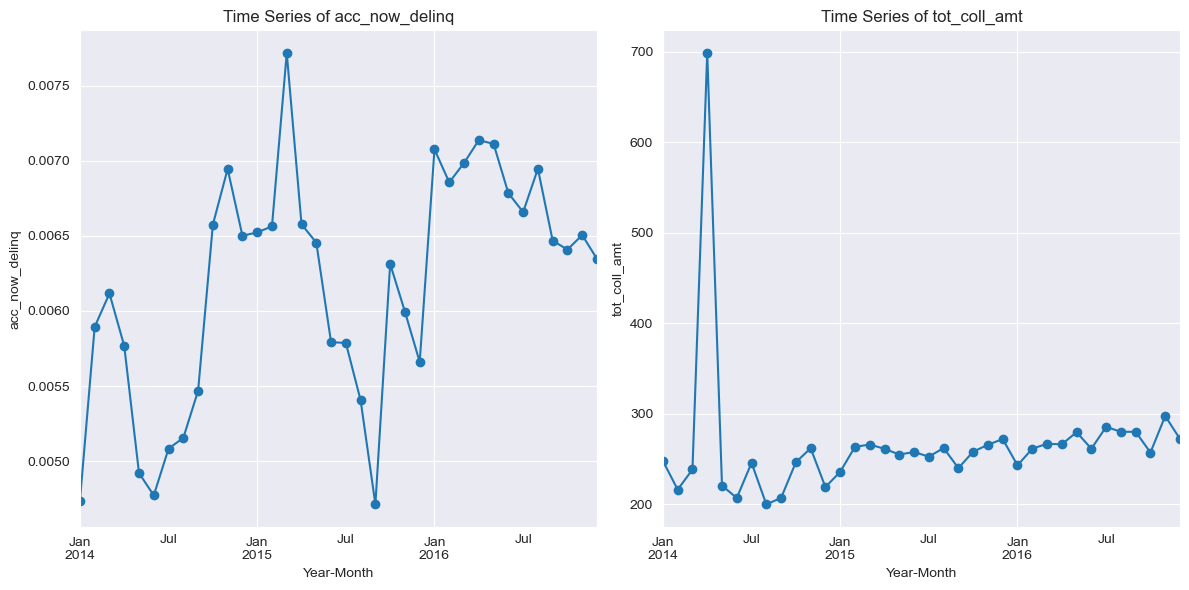

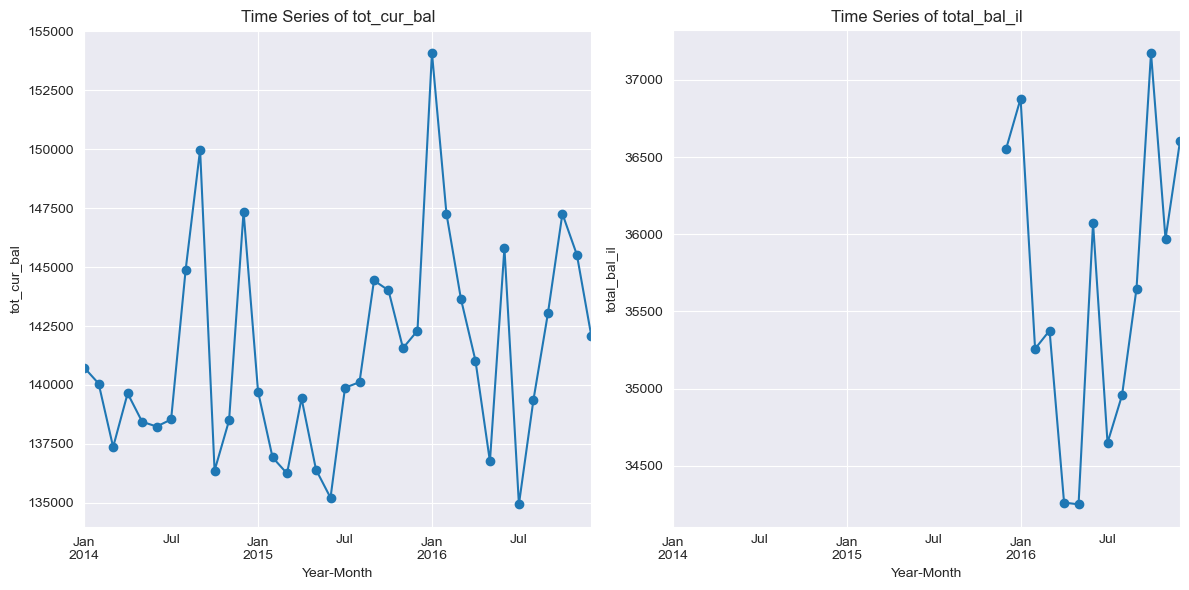

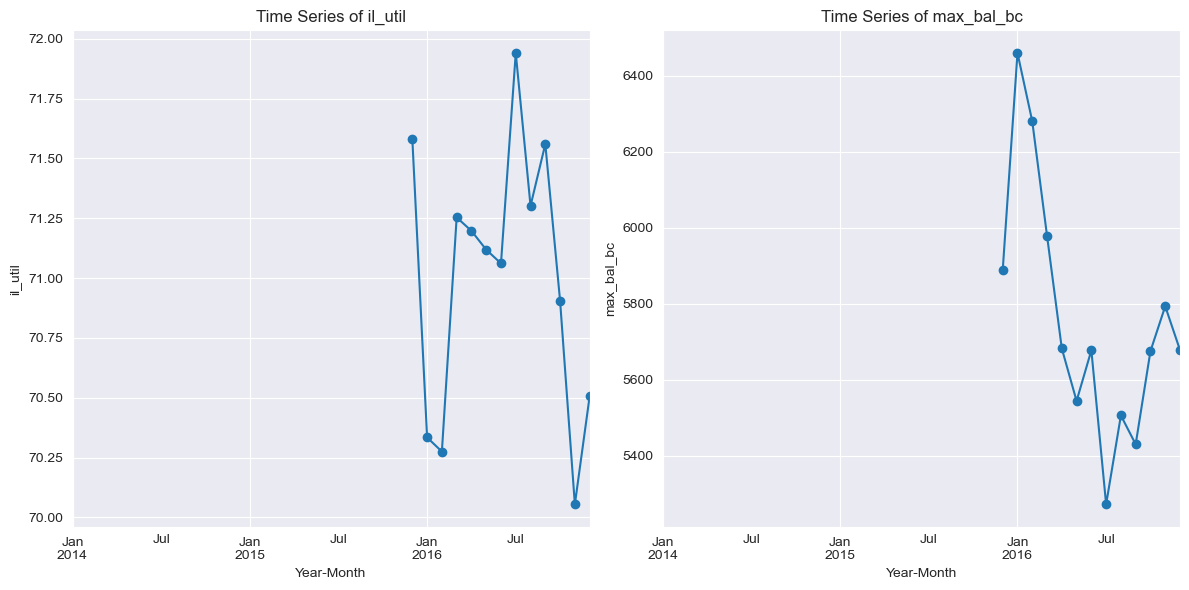

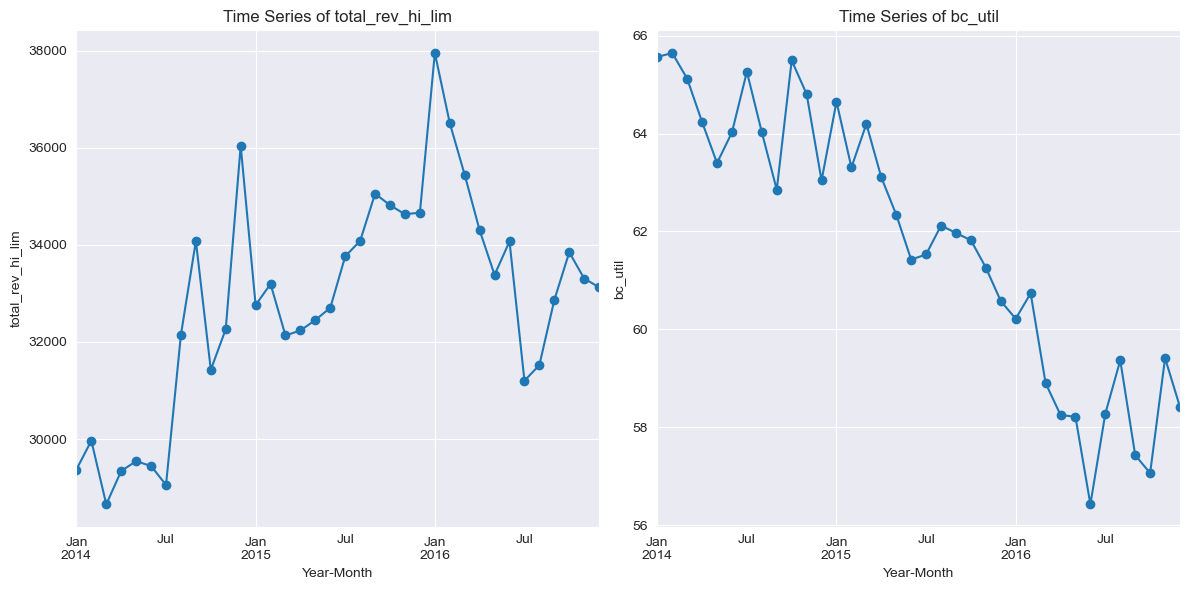

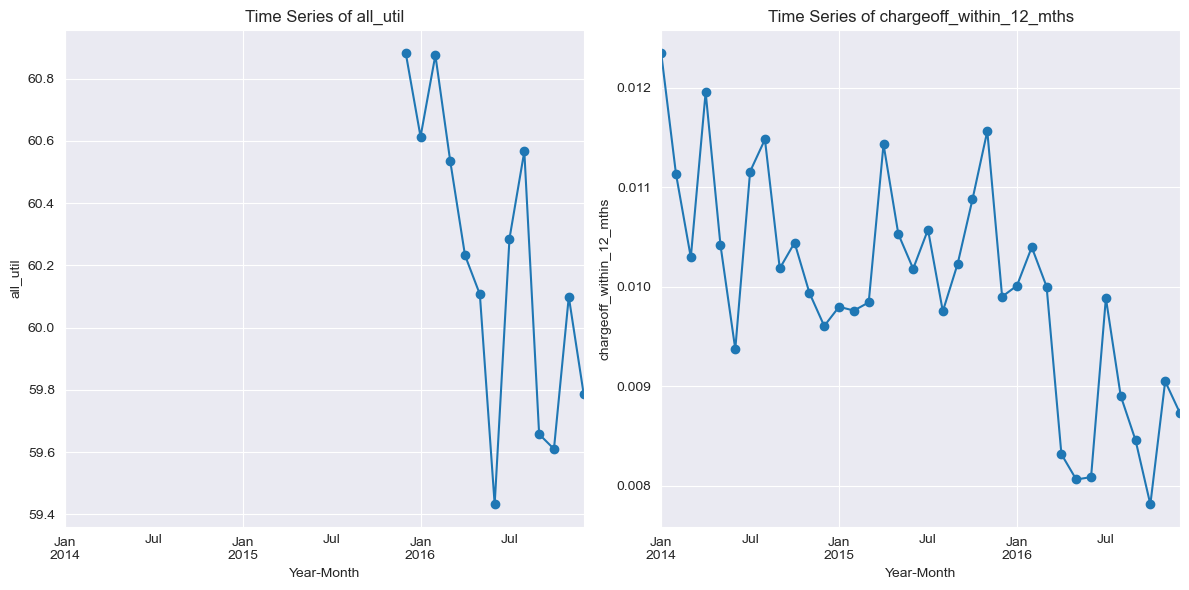

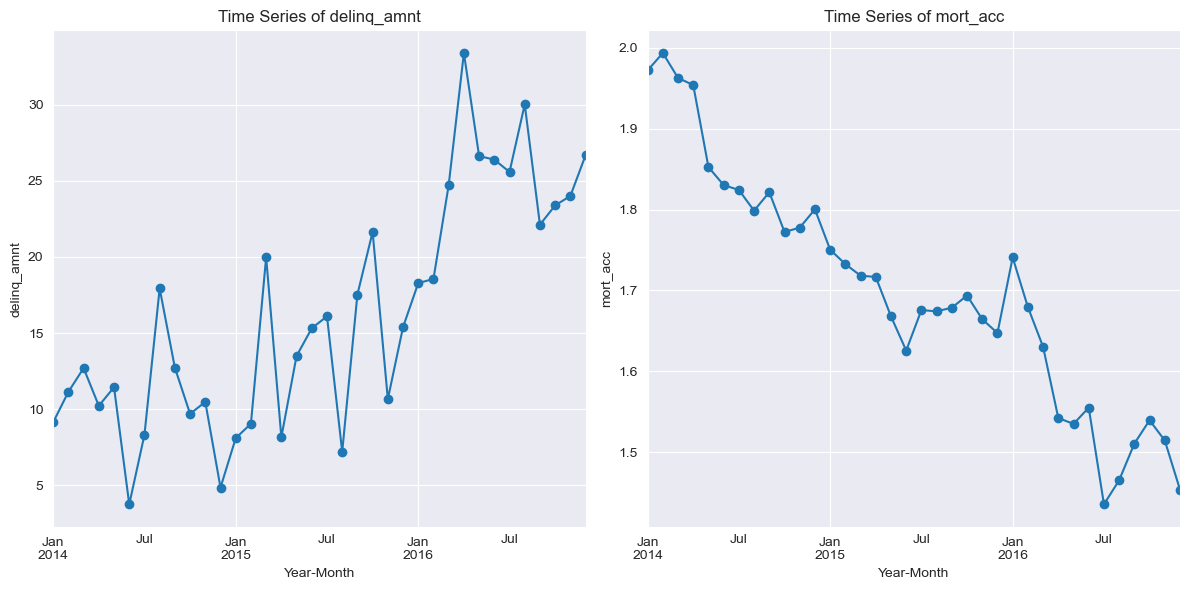

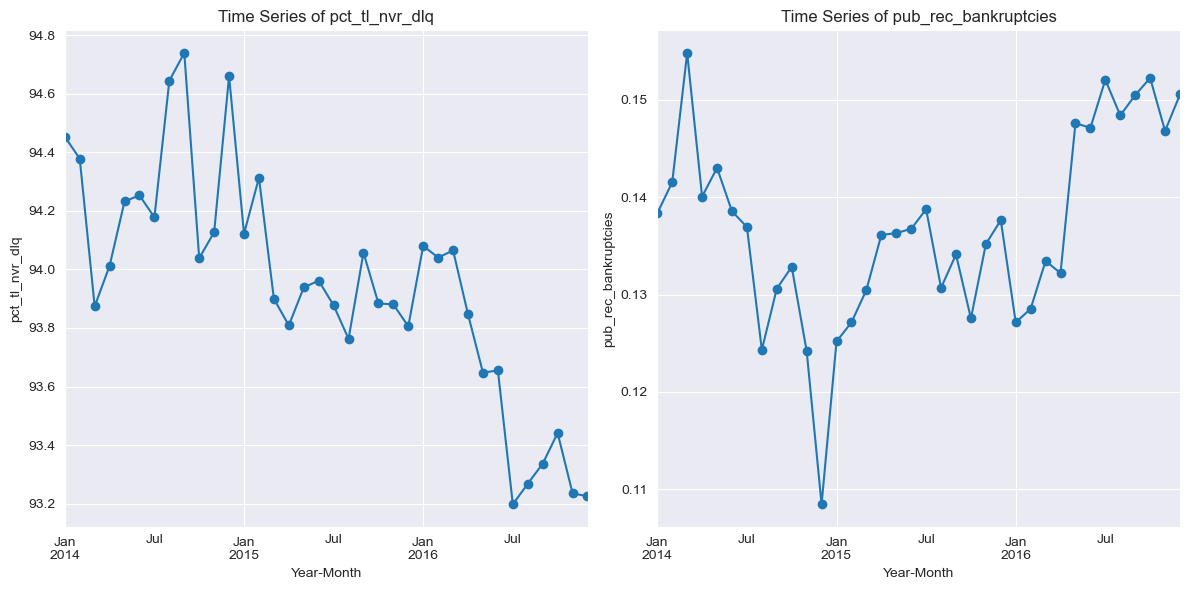

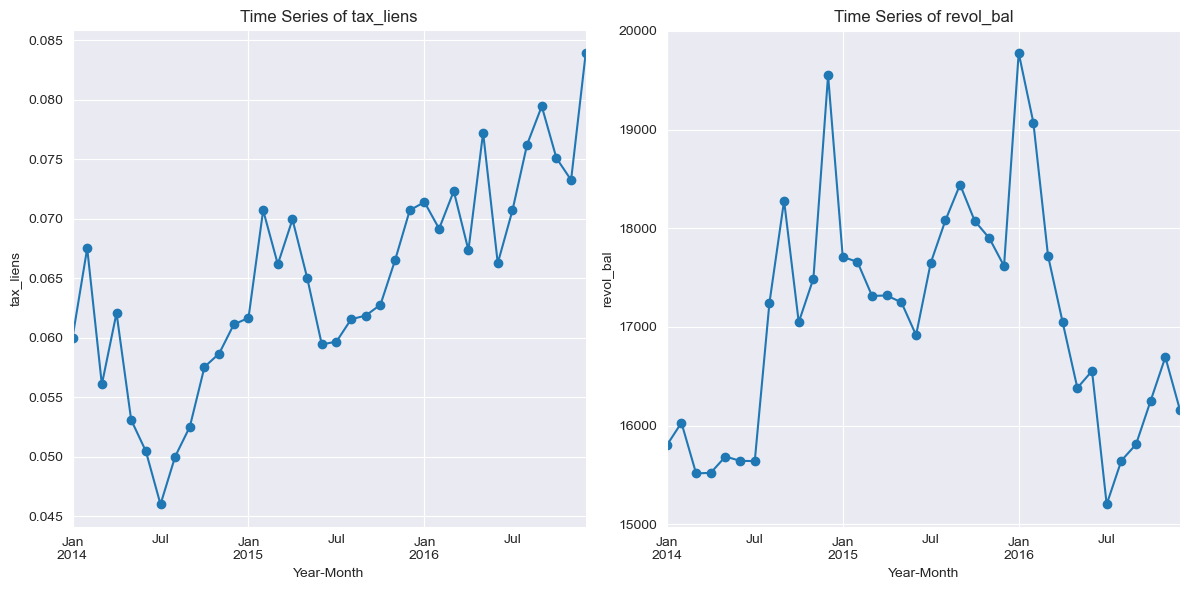

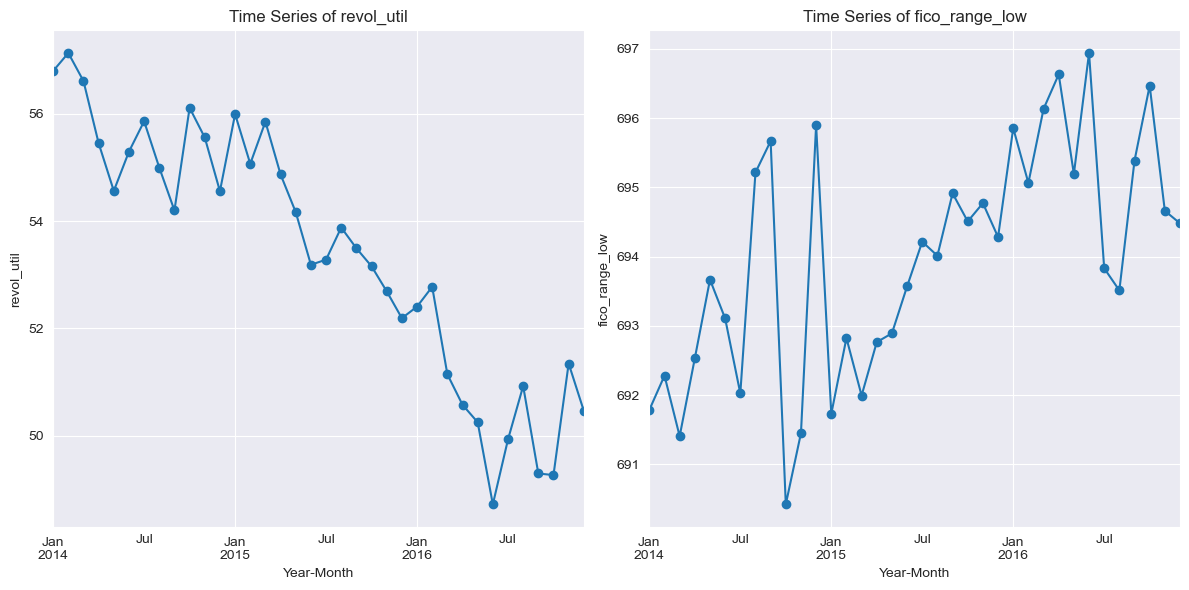

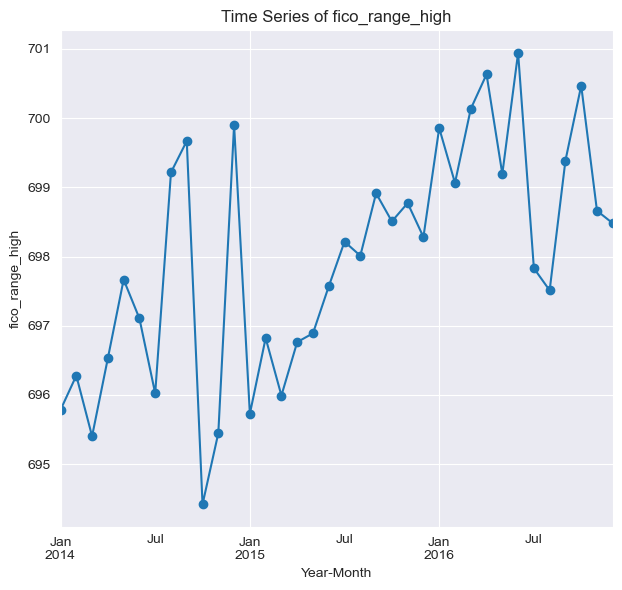

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'input_data' is already defined and contains the necessary data

# Create 'year_month_column' from 'issue_d'
input_data['issue_d'] = pd.to_datetime(input_data['issue_d'])  # Let pandas infer the format or you can use format='ISO8601'
input_data['year_month_column'] = input_data['issue_d'].dt.to_period('M')  # Create 'YYYY-MM' format

# Define the function to plot time series for numerical columns in separate windows
def plot_time_series_for_columns_separate_windows(dataframe, numerical_columns, time_column):
    for i in range(0, len(numerical_columns), 2):  # Loop in steps of 2
        plt.figure(figsize=(12, 6))  # Create a new figure for each set of columns
        
        # Plot two columns per figure
        for j in range(2):
            if i + j < len(numerical_columns):  # Check if the index is within bounds
                col = numerical_columns[i + j]
                
                # Aggregate data by time (monthly mean or sum)
                aggregated_data = dataframe.groupby(time_column)[col].mean()  # You can switch to sum() or other aggregations
                
                # Plot time series
                plt.subplot(1, 2, j + 1)  # Two plots in one row
                aggregated_data.plot(marker='o')
                plt.title(f'Time Series of {col}')
                plt.xlabel('Year-Month')
                plt.ylabel(col)
        
        plt.tight_layout()
        plt.show()  # Display the figure

# List of numerical columns to be plotted
numerical_columns = [
    'loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 'pub_rec', 'open_acc', 
    'total_acc', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 
    'total_bal_il', 'il_util', 'max_bal_bc', 'total_rev_hi_lim', 'bc_util', 'all_util', 'chargeoff_within_12_mths', 
    'delinq_amnt', 'mort_acc', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'revol_bal', 
    'revol_util', 'fico_range_low', 'fico_range_high'
]

# Call the function to plot the time series in separate windows
plot_time_series_for_columns_separate_windows(input_data, numerical_columns, time_column='year_month_column')


# 3. Correlation Analysis

Create a correlation matrix to explore relationships between numerical variables such as price, number_of_reviews, availability_365, and review_scores_rating. Identify any strong correlations that might be useful for predictive modeling or further investigation.

Plotting correlation matrix and heatmap for the required attributes

Plotting correlation matrix and heatmap for additional attributes

2024-10-09 14:13:43 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000021ED12C02F0>


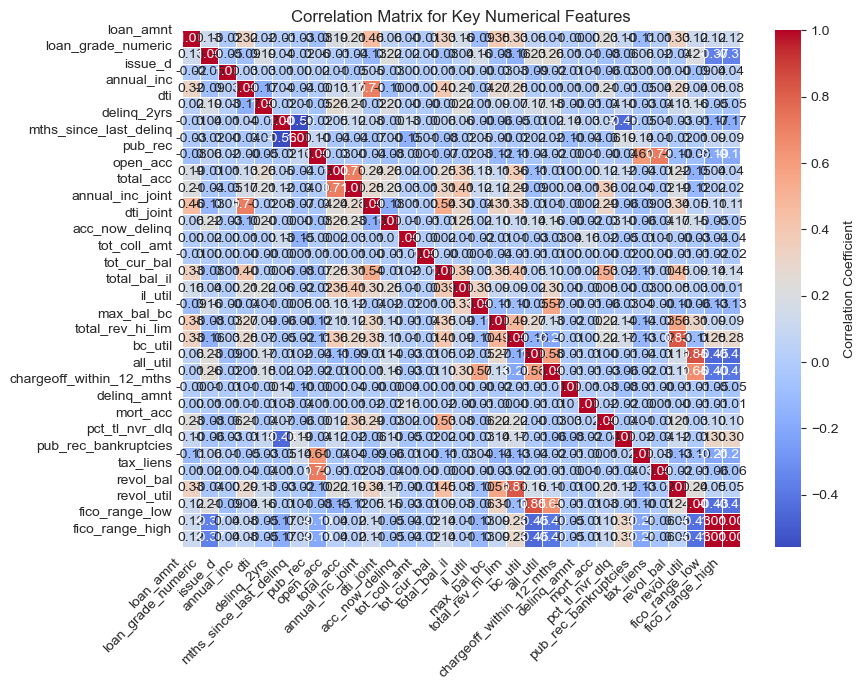

,loan_amnt,loan_grade_numeric,issue_d,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,pub_rec,open_acc,total_acc,...,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,revol_bal,revol_util,fico_range_low,fico_range_high
loan_amnt,1.000000,0.133697,-0.019306,0.318449,0.023334,-0.007615,-0.026717,-0.076860,0.187655,0.210826,...,-0.002759,0.001028,0.233677,0.096624,-0.112558,0.007195,0.331926,0.124372,0.124144,0.124142
loan_grade_numeric,0.133697,1.000000,-0.050155,-0.085618,0.185145,0.039095,-0.017757,0.058527,-0.005774,-0.040246,...,0.010515,0.006006,-0.075342,-0.055943,0.061410,0.016119,-0.044131,0.206014,-0.365971,-0.365968
issue_d,-0.019306,-0.050155,1.000000,0.025311,0.025028,0.008631,0.000879,0.020988,0.008974,-0.054686,...,-0.006151,0.006862,-0.061898,-0.030717,0.009866,0.014812,0.001071,-0.087608,0.036693,0.036693
annual_inc,0.318449,-0.085618,0.025311,1.000000,-0.165100,0.038939,-0.042442,-0.004723,0.131807,0.168864,...,0.007561,0.007198,0.214834,-0.005879,-0.050884,0.041627,0.285176,0.042948,0.077234,0.077234
dti,0.023334,0.185145,0.025028,-0.165100,1.000000,-0.016329,0.006091,-0.054583,0.263042,0.206436,...,-0.004556,-0.007024,-0.042236,0.097269,-0.034826,-0.035926,0.126121,0.160221,-0.051571,-0.051574
delinq_2yrs,-0.007615,0.039095,0.008631,0.038939,-0.016329,1.000000,-0.556397,-0.024500,0.048718,0.118086,...,0.141261,0.031069,0.071640,-0.451527,-0.052609,0.008986,-0.031964,-0.014755,-0.173813,-0.173811
mths_since_last_delinq,-0.026717,-0.017757,0.000879,-0.042442,0.006091,-0.556397,1.000000,0.097451,-0.044091,-0.040822,...,-0.101186,-0.036588,-0.055322,0.190419,0.137998,0.007977,-0.022264,0.007548,0.086590,0.086590
pub_rec,-0.076860,0.058527,0.020988,-0.004723,-0.054583,-0.024500,0.097451,1.000000,-0.032855,0.000661,...,-0.003977,0.005445,-0.003339,-0.036964,0.613314,0.720308,-0.100865,-0.078590,-0.193382,-0.193380
open_acc,0.187655,-0.005774,0.008974,0.131807,0.263042,0.048718,-0.044091,-0.032855,1.000000,0.709229,...,0.004206,0.003385,0.119433,0.119663,-0.036186,-0.010943,0.224641,-0.151546,0.038862,0.038861
total_acc,0.210826,-0.040246,-0.054686,0.168864,0.206436,0.118086,-0.040822,0.000661,0.709229,1.000000,...,0.042008,0.006514,0.359724,0.020963,0.037579,-0.024703,0.185358,-0.116911,0.023059,0.023057


In [12]:
#List of columns
correlation_columns = ['loan_amnt','loan_grade_numeric', 'issue_d', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 'pub_rec', 'open_acc', 'total_acc', 
                 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_bal_il', 'il_util', 
                 'max_bal_bc', 'total_rev_hi_lim', 'bc_util', 'all_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc',
                 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'revol_bal', 'revol_util', 'fico_range_low', 'fico_range_high']




# Convert columns to numeric, invalid parsing will be set as NaN
correlation_data = input_data[correlation_columns].apply(pd.to_numeric, errors='coerce')
correlation_data.head()
# Creating the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix


In [13]:
# Set the correlation threshold
correlation_threshold = 0.1

# Get the correlation values for 'loan_grade_numeric'
correlation_with_grade = correlation_matrix['loan_grade_numeric']

# Select columns with correlation greater than 0.2
selected_columns = correlation_with_grade[correlation_with_grade.abs() > correlation_threshold].index.tolist()

# Remove 'loan_grade_numeric' from the list of selected columns if it's included
if 'loan_grade_numeric' in selected_columns:
    selected_columns.remove('loan_grade_numeric')

# Display the selected columns
print(f"Columns with a correlation greater than {correlation_threshold} with 'loan_grade_numeric':")
print(selected_columns)

Columns with a correlation greater than 0.1 with 'loan_grade_numeric':
['loan_amnt', 'dti', 'annual_inc_joint', 'dti_joint', 'il_util', 'total_rev_hi_lim', 'bc_util', 'all_util', 'revol_util', 'fico_range_low', 'fico_range_high']


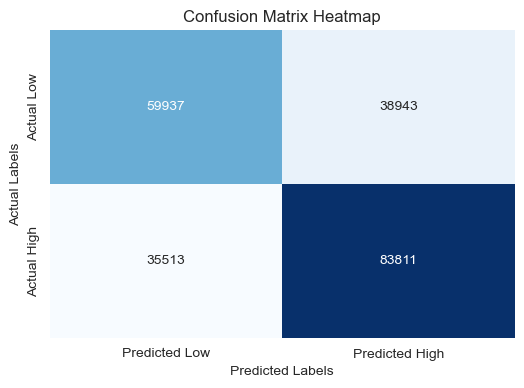

Classification Report:
              precision    recall  f1-score   support

        High       0.63      0.61      0.62     98880
         Low       0.68      0.70      0.69    119324

    accuracy                           0.66    218204
   macro avg       0.66      0.65      0.65    218204
weighted avg       0.66      0.66      0.66    218204

Confusion Matrix:
[[59937 38943]
 [35513 83811]]


In [14]:
# KNN using high_low
X = input_data[selected_columns]  
Y = input_data['high_low'] 

X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted Low', 'Predicted High'], 
            yticklabels=['Actual Low', 'Actual High'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

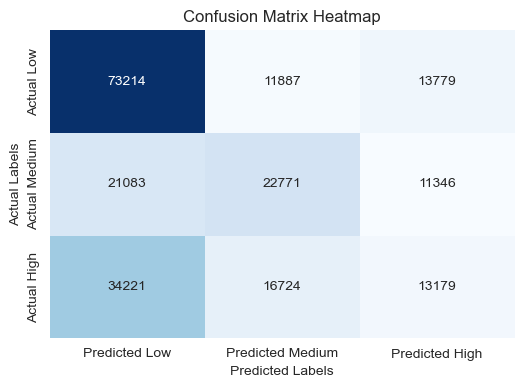

Classification Report:
              precision    recall  f1-score   support

        High       0.57      0.74      0.64     98880
         Low       0.44      0.41      0.43     55200
      Medium       0.34      0.21      0.26     64124

    accuracy                           0.50    218204
   macro avg       0.45      0.45      0.44    218204
weighted avg       0.47      0.50      0.48    218204

Confusion Matrix:
[[73214 11887 13779]
 [21083 22771 11346]
 [34221 16724 13179]]


In [15]:
# Train KNN using high_medium_low
X = input_data[selected_columns]  
Y = input_data['high_medium_low'] 

# Fill missing values and split the data
X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn.predict(X_test_scaled)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted Low', 'Predicted Medium', 'Predicted High'], 
            yticklabels=['Actual Low', 'Actual Medium', 'Actual High'])  # Fixed label issue
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# 4. Price Analysis

Analyze the distribution of prices across different neighborhoods (host_neighbourhood) or room types (if available). Understand which neighborhoods have higher or lower average prices and whether certain neighborhoods are more popular for shortterm or longterm stays.

# 5. Neighborhood Comparison

Compare the average review_scores_rating across different neighborhoods. Determine if certain neighborhoods have consistently higher ratings, which could indicate better or worse guest experiences.

# 6. Outlier Detection

Identify outliers in the dataset, particularly in price, minimum_nights, and review_scores_rating.

# Detecting outliers using IQR

Calculating summary statistics after dropping outliers according to IQR method

Visualizing after outlier removal using IQR

Visualizing after outlier removal using Z Score

# Text Length

Create a new feature that measures the length of each
review (number of words or characters). Determine if the length of a review
correlates with its sentiment or the review scores.

# Keyword Extraction

Identify and count the occurrence of specific keywords (e.g., "clean,"
"comfortable," "noisy") in the reviews. Generate new features based on the
presence of these keywords, which might influence guest satisfaction